# Import the Neccesary Libraries #

In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow import feature_column
from tensorflow.keras import layers
from keras.models import load_model

# Import the CSV Training and Testing Data Sets #

In [2]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)
train=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\PortTraining_1404_002_FINAL_startingAt24.csv')
test=pd.read_csv(r'C:\Users\Daniel\OneDrive - University of Massachusetts Dartmouth\ECE457_Senior_Design_ECE5\CSV_Files\StbdTesting_1404_002_FINAL.csv')

In [ ]:
train

In [ ]:
test

# Split up the Features and Labels from both the Training and Testing Datasets #

In [3]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,4:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]


x_test=test.iloc[:,4:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

In [ ]:
y_test

In [ ]:
x_train

# Scale the Feaures from -1 to 1 so that Training is Easier for the Model #

In [4]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(-1,1))
x_train_scale=s1.fit_transform(x_train)

s2=MinMaxScaler(feature_range=(-1,1))
x_test_scale=s2.fit_transform(x_test)
x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

5480118
5480118


# Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data #

In [5]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

5480118
5480118
[ 0.         59.66499867 54.53999878 ... 80.93999819 80.6249982
 80.92499819]
5480118
[ 0.         55.83499875 55.83499875 ... 80.5849982  79.48499822
 78.55499824]
5480118


# Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function #

In [33]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4278
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=10 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=NumSampsPerPing # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=21

test_data=x_test_scale
test_targets=y_test_scale

dataRows= data.shape[0]
validationStartRow= dataRows-NumSampsPerPing*281
#print(validationStartRow, ',', dataRows)

#split up the training data into a validation set and training set
train_data=data[:validationStartRow-1]
train_targets=targets[:validationStartRow-1]
val_data=data[validationStartRow:]
val_targets=targets[validationStartRow:]

inputs=TimeseriesGenerator(data=train_data, targets=train_targets,length=sequence_length, batch_size=batch_size)
val_inputs=TimeseriesGenerator(data=val_data, targets=val_targets,length=sequence_length, batch_size=batch_size)


#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(data=test_data, targets=test_targets,length=sequence_length, batch_size=batch_size)

#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

print('done')

done


In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = inputs[i]
	print('%s => %s' % (x, y))

In [ ]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = test_inputs[i]
	print('%s => %s' % (x, y))

# Define the Model's Structure #

In [31]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
# Make sure to ALWAYS use return_sequences=True when using series LSTM layers. MAKE SURE THAT THE LAST LSTM LAYER DOES NOT HAVE RETURN SEQUENCES=TRUE SINCE THE OUTPUT WILL BE 3D. return sequences makes the output shape of the layer
# equal its input. so in this case 3d.
model= Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(sequence_length,n_features), return_sequences=True, name='LSTM1'))
model.add(Dense(units=100))
#model.add(Dropout(0.2))

model.add(LSTM(units=416, activation='relu', return_sequences=True,name='LSTM2'))
model.add(Dense(units=100))
#model.add(Dropout(0.2))

model.add(LSTM(units=512, activation='relu', name='LSTM3', ))
model.add(Dense(units=100))
#model.add(Dropout(0.2))

#model.add(LSTM(units=320, activation='relu', return_sequences=True,name='LSTM4'))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480, activation='relu', return_sequences=True, name='LSTM5'))
#model.add(Dense(units=100))
#model.add(Dropout(0.2))


model.add(Dense(units=1)) #one output (namely: DOA)


In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 10, 64)            22016     
                                                                 
 LSTM2 (LSTM)                (None, 10, 416)           800384    
                                                                 
 LSTM3 (LSTM)                (None, 512)               1902592   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,725,505
Trainable params: 2,725,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def scheduler(epoch,lr):
    if epoch>=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.65
    else:
        return lr*tf.math.exp(-.5)

# Train the Model using the Specified Hyperparmeters #

Epoch 1/10
1000/1000 [==============================] - 321s 319ms/step - loss: 310.9124 - val_loss: 258.2701
Epoch 2/10
1000/1000 [==============================] - 327s 327ms/step - loss: 237.1689 - val_loss: 218.2812
Epoch 3/10
1000/1000 [==============================] - 320s 320ms/step - loss: 195.6410 - val_loss: 179.2357
Epoch 4/10
1000/1000 [==============================] - 313s 313ms/step - loss: 168.4549 - val_loss: 158.2764
Epoch 5/10
1000/1000 [==============================] - 312s 312ms/step - loss: 150.2918 - val_loss: 140.5193
Epoch 6/10
1000/1000 [==============================] - 312s 312ms/step - loss: 132.3438 - val_loss: 122.0885
Epoch 7/10
1000/1000 [==============================] - 315s 315ms/step - loss: 118.7523 - val_loss: 111.8562
Epoch 8/10
1000/1000 [==============================] - 318s 318ms/step - loss: 110.8867 - val_loss: 104.7164
Epoch 9/10
1000/1000 [==============================] - 314s 314ms/step - loss: 104.8710 - val_loss: 99.2001
Epoch 10/10

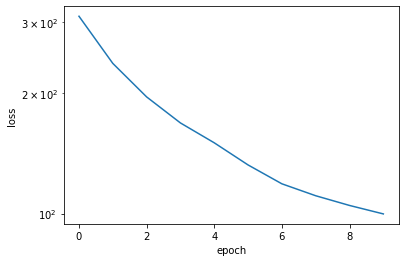

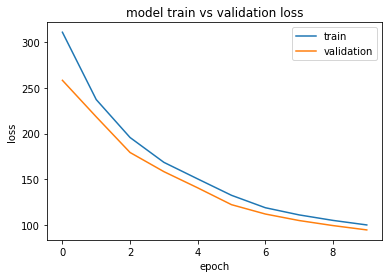

In [35]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=0.00001)#,decay=1e-5)
model.compile(loss='mse', optimizer=opt)

# Allow for early stopping so that the model does not overfit the training dataset
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

#callback=tf.keras.callbacks.LearningRateScheduler(scheduler)

t0=time.time()
history= model.fit(inputs,epochs=10,batch_size=None,verbose=1, callbacks=[es],validation_data=val_inputs)#, max_queue_size=200)
#history= model.fit(inputs)
t1=time.time()
print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model train vs validation loss')
plt.legend(['train','validation'], loc='upper right')


# Using the Model, Predict the DOA's on the Testing Dataset #

In [36]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

1281/1281 [==============================] - 135s 105ms/step


In [43]:
##predict on the training set just to see if the model has leant at all
predicted_train=model.predict(inputs, verbose=1)

1000/1000 [==============================] - 101s 101ms/step


# Compare the predicted and actual DOA's numerically #

In [44]:
print(predicted_train[0:21])

[[74.880516]
 [71.337425]
 [71.41524 ]
 [71.089035]
 [70.726006]
 [70.94615 ]
 [69.53365 ]
 [69.72257 ]
 [71.55461 ]
 [72.67217 ]
 [73.59474 ]
 [73.87956 ]
 [74.05273 ]
 [75.38338 ]
 [74.15825 ]
 [77.28589 ]
 [73.72394 ]
 [75.131836]
 [78.14093 ]
 [78.35191 ]
 [80.14264 ]]


In [46]:
print(y_test[10:32])

10    75.344998
11    49.974999
12    50.274999
13    62.839999
14    61.619999
15    75.429998
16    76.294998
17    62.244999
18    57.394999
19    59.214999
20    61.579999
21    63.259999
22    64.529999
23    52.299999
24    67.214998
25    81.694998
26    81.289998
27    71.434998
28    46.264999
29    47.084999
30    48.289999
31    63.984999
Name: DOA, dtype: float64


In [37]:
print(predicted[0:21])

[[58.48835 ]
 [57.18919 ]
 [56.56743 ]
 [57.632694]
 [57.063667]
 [57.710243]
 [59.166763]
 [59.271496]
 [59.366516]
 [60.361885]
 [60.30403 ]
 [59.622574]
 [58.458023]
 [56.78369 ]
 [57.089848]
 [55.658905]
 [55.113945]
 [55.192905]
 [53.85534 ]
 [53.974384]
 [54.029762]]


In [38]:
print(y_test[10:21])

10    75.344998
11    49.974999
12    50.274999
13    62.839999
14    61.619999
15    75.429998
16    76.294998
17    62.244999
18    57.394999
19    59.214999
20    61.579999
Name: DOA, dtype: float64


# Compare the Actual Testing DOA's to the Predicted DOA's Graphically #

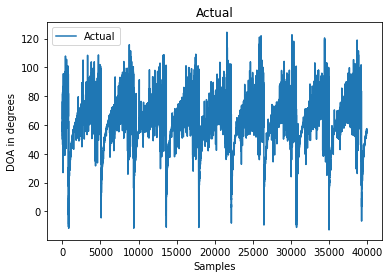

In [39]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


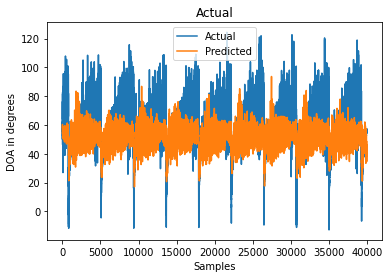

In [40]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



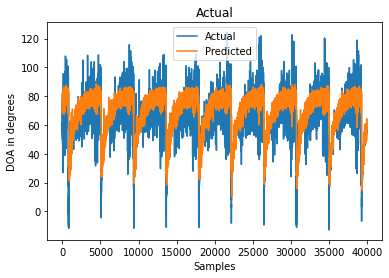

In [47]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_train[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

# Put the predicted DOA's back into a csv file format #

In [ ]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [ ]:
OutputCSVdf

In [ ]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\Daniel\\OneDrive - University of Massachusetts Dartmouth\\ECE457_Senior_Design_ECE5\\AIOutput_CSV_Files\\DL_PredictedOutputTestGood2Q.csv")

# Save the model #

In [ ]:
tf.keras.models.save_model(model,filepath="C:\\Users\\Daniel\\Desktop\\Models\\model_10.83Percent.h5")

# Load Previous Models and Use them to Predict #

In [ ]:
saved_model=tf.keras.models.load_model(filepath="C:\\Users\\Daniel\\Desktop\\Models\\model_10.83Percent.h5")

In [ ]:
predicted_saved=saved_model.predict(test_inputs)

In [ ]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_saved[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()

# EVERYTHING BELOW HERE IS MY KERAS TUNER STUFF. VIEWER REGRESSION IS ADVISED. #

In [ ]:
LOG_DIR = f"{int(time.time())}"

In [ ]:
def model_builder(hp):
    model= Sequential()

    #try
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units_1, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
    model.add(Dropout(0.2))

    for i in range(hp.Int("n_layers",1,2)):
        model.add(LSTM(units=hp.Int(f"LSTM_{i}_units", min_value=32, max_value=512, step=32), activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
        model.add(Dropout(0.2))

    #hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_2, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_3, activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_4 = hp.Int('units4', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_4, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(Dense(units=1)) #one output (namely: DOA)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,decay=1e-5)
    model.compile(loss='mse', optimizer=opt)

    return model

In [ ]:
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

tuner = kt.RandomSearch(model_builder, objective='loss', max_trials=1000, directory=os.path.normpath('C:/'))
tuner.search(inputs,steps_per_epoch=2000,epochs=20,verbose=1, callbacks=[es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. 
""")

In [ ]:
print(f"""
Unit1: {best_hps.get('units1')} learning rate {best_hps.get('learning_rate')} LSTM0 units: {best_hps.get('LSTM_0_units')} LSTM1 units: {best_hps.get('LSTM_1_units')} 
""")